In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!git clone https://github.com/NidhiAI/Librosa_wav_to_features

Cloning into 'Librosa_wav_to_features'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 56 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), 2.29 MiB | 5.16 MiB/s, done.


In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
#import csv
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

from keras import layers

#from sklearn.preprocessing import LabelEncoder#, StandardScalerimport keras
#from keras.models import Sequentialimport #, warnings
#warnings.filterwarnings('ignore')

Creating a header for our CSV file.

In [62]:
# create headers 
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [63]:
import csv
csvFilePath = "/kaggle/working/Librosa_wav_to_features/generatedFeatures/"
file = open(csvFilePath+'librosa.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
#genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
genres = 'male female'.split()
for g in genres:
    for filename in os.listdir(f'/kaggle/working/Librosa_wav_to_features/librosa_mp3/{g}'):
        songname = f'/kaggle/working/Librosa_wav_to_features/librosa_mp3/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        #rmse = librosa.feature.rmse(y=y)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open(csvFilePath+'librosa.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Data preprocessing: It involves loading CSV data, label encoding, feature scaling and data split into training and test set.

In [64]:
data = pd.read_csv('/kaggle/working/Librosa_wav_to_features/generatedFeatures/librosa.csv')
data.head() # all 6 wav to features 

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,Akshay_Kumar-1.wav,0.326013,0.061412,1242.978264,1383.492947,2211.111630,0.058998,-271.693207,144.071121,-20.575047,...,-8.720441,2.798906,-8.777470,-4.245789,-2.628192,-4.956270,-6.886003,-4.317806,-4.395898,male
1,John_Abraham-1.wav,0.318019,0.087968,1218.571704,1118.675713,2237.372185,0.080105,-262.468018,176.511597,-44.926266,...,-19.286688,-5.887372,-13.047683,-9.813202,6.346204,-18.739126,-1.797028,-4.955317,-12.663363,male
2,Naseeruddin_Shah-1.wav,0.376051,0.030630,914.042545,1206.285033,1733.750920,0.041394,-378.341675,169.019714,12.472123,...,-5.774904,3.557036,-7.931386,3.224374,2.571155,-1.076220,0.117292,-0.780932,1.522008,male
3,Ajay_Devgan-1.wav,0.454510,0.058343,943.347272,1141.943395,1731.471012,0.047535,-282.788025,178.429520,3.511111,...,-0.327627,5.948905,-8.002795,6.721773,1.588847,-0.663483,-4.799114,-2.028419,0.636516,male
4,Irfan_khan-1.wav,0.420686,0.047072,1434.471081,1502.665147,2855.788698,0.079537,-322.591614,136.801346,0.464059,...,-1.055776,6.614110,-6.891295,13.718536,-0.070882,-3.715560,2.912555,-2.153361,-1.757345,male


In [65]:
data.label.unique()

array(['male', 'female'], dtype=object)

In [66]:
data.label.value_counts()

male      8
female    6
Name: label, dtype: int64

In [68]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels

<AxesSubplot:xlabel='label', ylabel='count'>

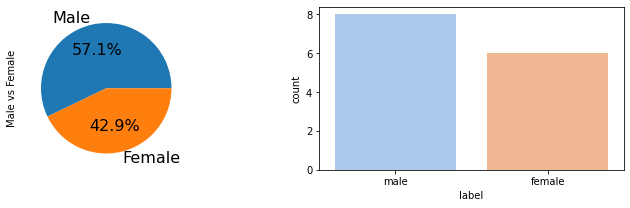

In [69]:
import seaborn as sns
plt.figure(figsize=(12, 3))

# left side graph
plt.subplot(1, 2, 1)
data.label.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Male", "Female"],
                                           ylabel="Male vs Female",
                                           autopct='%1.1f%%');
#plt.show()

# right side graph
plt.subplot(1, 2, 2)
sns.countplot(x="label",data=data, palette="pastel")

<AxesSubplot:>

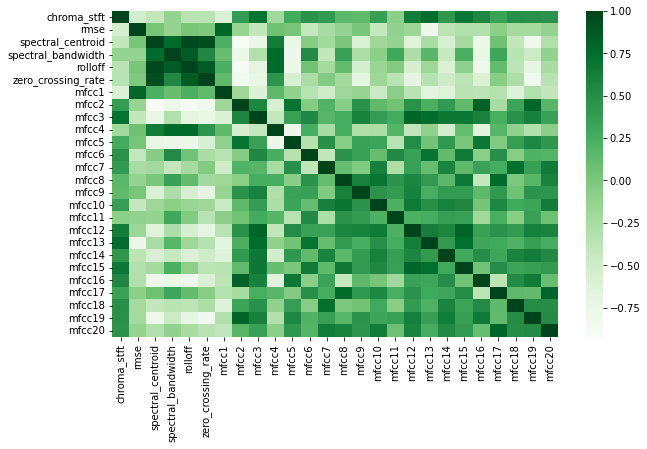

In [70]:
# check corerelation

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),cmap='Greens',annot=False)

In [71]:
# now we will convert these 2 values in 0/1 
# male to 0, female to 1
data.label.replace(['male', 'female'],[0,1], inplace=True)

In [72]:
data.sample(2)

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
1,0.318019,0.087968,1218.571704,1118.675713,2237.372185,0.080105,-262.468018,176.511597,-44.926266,34.910072,...,-19.286688,-5.887372,-13.047683,-9.813202,6.346204,-18.739126,-1.797028,-4.955317,-12.663363,0
5,0.400863,0.014618,803.082429,1065.387798,1374.635824,0.036154,-458.852997,166.025391,31.336935,21.340754,...,0.506921,6.600809,-0.597324,5.325176,2.121905,-1.066245,2.724939,0.938227,0.421700,0


x and y split

In [73]:
# Divive data into x(Independent variables) and y (Target/Dependent variable) 
x = data.drop("label", axis= 1)
y = data["label"]

In [74]:
# Print x 
print(x.shape)
x.head(2)

(14, 26)


,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.326013,0.061412,1242.978264,1383.492947,2211.111630,0.058998,-271.693207,144.071121,-20.575047,11.612088,...,-0.449929,-8.720441,2.798906,-8.777470,-4.245789,-2.628192,-4.956270,-6.886003,-4.317806,-4.395898
1,0.318019,0.087968,1218.571704,1118.675713,2237.372185,0.080105,-262.468018,176.511597,-44.926266,34.910072,...,-4.592168,-19.286688,-5.887372,-13.047683,-9.813202,6.346204,-18.739126,-1.797028,-4.955317,-12.663363


In [75]:
# Print y 
print(y.shape)
y.head(2)

(14,)


0    0
1    0
Name: label, dtype: int64

In [76]:
#Separate out objects and numeric columns in x  
cat_cols = x.columns[x.dtypes == 'object']
num_cols = x.columns[(x.dtypes == 'float64') | (x.dtypes == 'int64')]
# num_cols1=list(x.select_dtypes(exclude='object').columns) # can do this way also 

In [77]:
cat_cols 

# no categorical columns in x , so we do not need to apply onehot or get_dummies 

Index([], dtype='object')

In [78]:
# Now we will scale numeric columns
num_cols


Index(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20'],
      dtype='object')

Standardisation

In [79]:
#applying scalar to all numeric columns 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#x[num_cols]=scaler.fit_transform(x[num_cols]) # no categorical columns, so can go with below 
x=scaler.fit_transform(x)

Train Test split

In [80]:
#Sample for training and testing the model
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.4, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8, 26), (6, 26), (8,), (6,))

In [81]:
##Modeling - AIML
#from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB 

#Evaluation
from sklearn import metrics

# confusion matrix
import sklearn.metrics

Train models

In [82]:
#Build base models
lr = LogisticRegression(random_state=0).fit(X_train, Y_train)
rf = RandomForestClassifier(n_estimators = 7).fit(X_train, Y_train)
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)
svc = SVC().fit(X_train, Y_train)
#nb = ComplementNB().fit(X_train, Y_train) # can not run this with negative values in data
nb = GaussianNB().fit(X_train, Y_train)

Predict on Train dataset

In [83]:
# Prediction on Train data set 
lr_pred = lr.predict(X_train)
rf_pred = rf.predict(X_train)
knn_pred = knn.predict(X_train)
svc_pred = svc.predict(X_train)
nb_pred = nb.predict(X_train)

lr_train_score_1 = 100*metrics.accuracy_score(Y_train, lr_pred)
rf_train_score_1 = 100*metrics.accuracy_score(Y_train, rf_pred)
knn_train_score_1 = 100*metrics.accuracy_score(Y_train, knn_pred)
svc_train_score_1 = 100*metrics.accuracy_score(Y_train, svc_pred)
nb_train_score_1 = 100*metrics.accuracy_score(Y_train, nb_pred)


print("Train Accuracy score of LR = ",lr_train_score_1)
print("Train Accuracy score of RF = ",rf_train_score_1)
print("Train Accuracy score of KNN = ",knn_train_score_1)
print("Train Accuracy score of SVC = ",svc_train_score_1)
print("Train Accuracy score of NB = ",nb_train_score_1)

Train Accuracy score of LR =  100.0
Train Accuracy score of RF =  100.0
Train Accuracy score of KNN =  87.5
Train Accuracy score of SVC =  100.0
Train Accuracy score of NB =  100.0


Predict on Test dataset

In [84]:
# Prediction on Test data set 
lr_pred_test = lr.predict(X_test)
rf_pred_test = rf.predict(X_test)
knn_pred_test = knn.predict(X_test)
svc_pred_test = svc.predict(X_test)
nb_pred_test = nb.predict(X_test)



In [85]:
lr_test_score_1 = 100*metrics.accuracy_score(Y_test, lr_pred_test)
rf_test_score_1 = 100*metrics.accuracy_score(Y_test, rf_pred_test)
knn_test_score_1 = 100*metrics.accuracy_score(Y_test, knn_pred_test)
svc_test_score_1 = 100*metrics.accuracy_score(Y_test, svc_pred_test)
nb_test_score_1 = 100*metrics.accuracy_score(Y_test, nb_pred_test)

print("Test Accuracy score of LR = ",lr_test_score_1)
print("Test Accuracy score of RF = ",rf_test_score_1)
print("Test Accuracy score of KNN = ",knn_test_score_1)
print("Test Accuracy score of SVC = ",svc_test_score_1)
print("Test Accuracy score of NB = ",nb_test_score_1)

Test Accuracy score of LR =  83.33333333333334
Test Accuracy score of RF =  66.66666666666666
Test Accuracy score of KNN =  100.0
Test Accuracy score of SVC =  83.33333333333334
Test Accuracy score of NB =  100.0


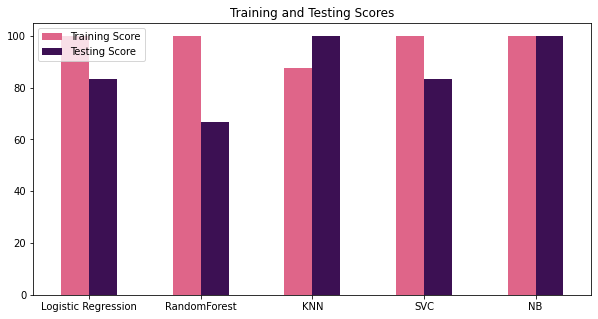

In [86]:
# Plot graph to compare models for Training and Testing Scores
trainScores = [lr_train_score_1, rf_train_score_1, knn_train_score_1, svc_train_score_1, nb_train_score_1]

testScores = [lr_test_score_1, rf_test_score_1, knn_test_score_1, svc_test_score_1, nb_test_score_1]

indices = ['Logistic Regression', 'RandomForest', 'KNN', 'SVC' , 'NB']

scores = pd.DataFrame({'Training Score': trainScores,'Testing Score': testScores}, index=indices)

plot = scores.plot.bar(figsize=(10, 5), rot=0, color=['#df6589ff', '#3c1053ff'])

plt.title('Training and Testing Scores')
plt.show()

In [87]:
# print scores dataframe created above 
scores.sort_values(by='Testing Score', ascending=False, inplace = True)
scores

,Training Score,Testing Score
KNN,87.5,100.000000
NB,100.0,100.000000
Logistic Regression,100.0,83.333333
SVC,100.0,83.333333
RandomForest,100.0,66.666667


Confusion Matrix

In [88]:
predVals = pd.DataFrame(data={'truth': Y_test, 
                              'Logisticregression': lr_pred_test, 
                              'RandomForest': rf_pred_test, 
                              'KNN': knn_pred_test, 
                              'SVC': svc_pred_test, 
                              'NaiveBayes': nb_pred_test})

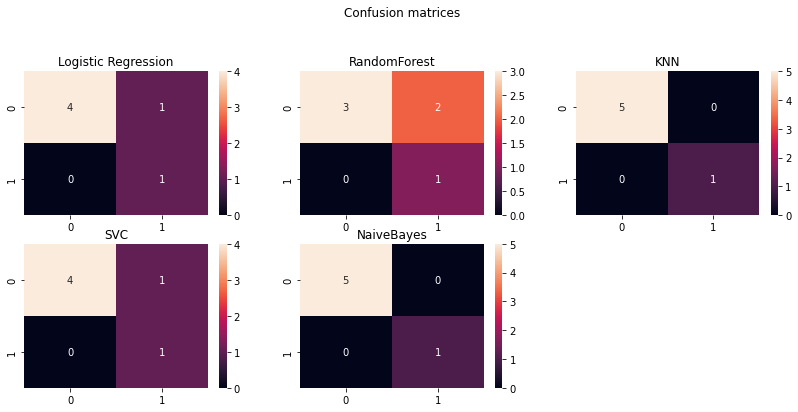

In [89]:
plt.figure(figsize=(14, 9))

plt.subplot(3, 3, 1)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, lr_pred_test), annot=True).set(title='Logistic Regression')

plt.subplot(3, 3, 2)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, rf_pred_test), annot=True).set(title='RandomForest')

plt.subplot(3, 3, 3)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, knn_pred_test), annot=True).set(title='KNN')

plt.subplot(3, 3, 4)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, svc_pred_test), annot=True).set(title='SVC')

plt.subplot(3, 3, 5)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, nb_pred_test), annot=True).set(title='NaiveBayes')

plt.suptitle('Confusion matrices')
plt.show()

Classification reports

In [90]:
print("<< Logistic Regression >> \n\n", sklearn.metrics.classification_report(Y_test, lr_pred_test))

<< Logistic Regression >> 

               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



In [91]:
print("<< Random Forest >>\n\n", sklearn.metrics.classification_report(Y_test, rf_pred_test))

<< Random Forest >>

               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6



In [92]:
print("<< K Nearest Neighbour >>\n\n", sklearn.metrics.classification_report(Y_test, knn_pred_test))

<< K Nearest Neighbour >>

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [93]:
print("<< Supprt Vector >>\n\n", sklearn.metrics.classification_report(Y_test, svc_pred_test))

<< Supprt Vector >>

               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



In [94]:
print("<< Naive Bayes >>\n\n", sklearn.metrics.classification_report(Y_test, nb_pred_test))

<< Naive Bayes >>

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [95]:
predVals.sample(6)

,truth,Logisticregression,RandomForest,KNN,SVC,NaiveBayes
10,1,1,1,1,1,1
2,0,0,0,0,0,0
6,0,0,0,0,0,0
4,0,0,1,0,0,0
3,0,0,0,0,0,0
7,0,1,1,0,1,0


now apply depp neural network on this to compare (ANN)
https://www.kaggle.com/datasets/primaryobjects/voicegender